In [ ]:
!pip install geemap    # A Python package for interactive mapping with Google Earth Engine
!pip install geopandas # make working with geospatial data in python easier
!pip install tqdm
#!pip -q install geojason
!pip install rasterio  # to work with geospatial raster data
!pip -q install --upgrade folium  # Folium is a Python library used for visualizing geospatial data. 

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
% matplotlib inline

import rasterio as rio
from rasterio.plot import show
import rasterio.mask

import geopandas as gpd
import numpy as np
import pandas as pd

from rasterio import windows
from shapely.geometry import box    # Shapely - Python package for set-theoretic analysis and manipulation of planar features using functions from GEOS library
import pandas as pd

import ee
import geemap
import geemap.eefolium as emap

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Authenticate Google EE

In [5]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=KsKJwSl4Tq09DPDnfVWcgftheGhJzND_v7pMWa0wB9g&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhkjZhiwX67Oy-friyGUDIykgBttEA2y16qsiTEc6DpM3AC4t4i2rk

Successfully saved authorization token.


## Fetch Kenya county layer from drive

In [11]:
kenya_counties = gpd.read_file('/gdrive/MyDrive/Omdena/Kenya/Data collection/kenya_counties.gpkg')

## Exploring counties

In [12]:
kenya_counties.head()

,OBJECTID,AREA_,PERIMETER,COUNTY3_,COUNTY3_ID,COUNTY,Shape_Leng,Shape_area,Shape_len,geometry
0,1.0,5.677,15.047,2.0,1.0,Turkana,15.046838,5.676985,15.046838,"POLYGON ((35.79593 5.34449, 35.79659 5.34468, ..."
1,2.0,6.177,11.974,3.0,2.0,Marsabit,11.974165,6.176831,11.974165,"POLYGON ((36.05061 4.45622, 36.23184 4.45124, ..."
2,3.0,2.117,7.355,4.0,3.0,Mandera,7.355154,2.117196,7.355154,"POLYGON ((41.62133 3.97673, 41.62272 3.97860, ..."
3,4.0,4.610,9.838,5.0,4.0,Wajir,9.838408,4.609589,9.838408,"POLYGON ((39.31812 3.47197, 39.31956 3.47168, ..."
4,5.0,0.740,5.030,6.0,5.0,West Pokot,5.030271,0.740481,5.030271,"POLYGON ((35.12745 2.62271, 35.12762 2.62302, ..."


In [10]:
kenya_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    165 non-null    float64 
 1   AREA_       165 non-null    float64 
 2   PERIMETER   165 non-null    float64 
 3   COUNTY3_    165 non-null    float64 
 4   COUNTY3_ID  165 non-null    float64 
 5   COUNTY      165 non-null    object  
 6   Shape_Leng  165 non-null    float64 
 7   Shape_area  165 non-null    float64 
 8   Shape_len   165 non-null    float64 
 9   geometry    165 non-null    geometry
dtypes: float64(8), geometry(1), object(1)
memory usage: 13.0+ KB


In [33]:
pd.unique(kenya_counties['COUNTY'])

array(['Turkana', 'Marsabit', 'Mandera', 'Wajir', 'West Pokot', 'Samburu',
       'Isiolo', 'Baringo', 'Keiyo-Marakwet', 'Trans Nzoia', 'Bungoma',
       'Garissa', 'Uasin Gishu', 'Kakamega', 'Laikipia', 'Busia', 'Meru',
       'Nandi', 'Siaya', 'Nakuru', 'Vihiga', 'Nyandarua', 'Tharaka',
       'Kericho', 'Kisumu', 'Nyeri', 'Tana River', 'Kitui', 'Kirinyaga',
       'Embu', 'Homa Bay', 'Bomet', 'Nyamira', 'Narok', 'Kisii',
       "Murang'a", 'Migori', 'Kiambu', 'Machakos', 'Kajiado', 'Nairobi',
       'Makueni', 'Lamu', 'Kilifi', 'Taita Taveta', 'Kwale', 'Mombasa'],
      dtype=object)

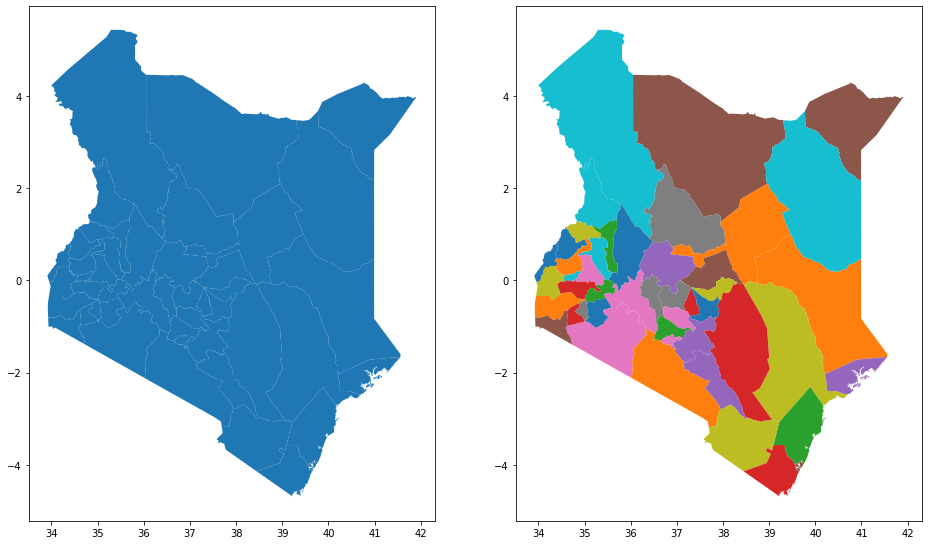

In [28]:
#kenya_counties.plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
kenya_counties.plot(ax=ax1)
kenya_counties.plot('COUNTY',ax=ax2)
plt.show()

## Generate a sentinel 2A image for Kenya

In [46]:
# defining parameters

def generate_image(region, centroid, product='COPERNICUS/S2', min_date='2020-01-01', max_date='2020-01-31', 
                   bands='RGBNIR', range_min=0, range_max=2000, cloud_pct=10, debug=True):
  
  # generating Sentinel-2 image using GEE
  image = ee.ImageCollection(product).filterBounds(region).filterDate(str(min_date), str(max_date)).filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct)).mosaic()

 # if bands == 'ALL_BANDS':
 #  imaage = image.select('B.+')
  
  if bands == 'RGBNIR':
    image = image.select('B4', 'B3', 'B2', 'B8')

  elif bands == 'RGB':
    image = image.select('B4', 'B3', 'B2')

  elif bands == 'RGB_NIR_SWIR1':
    image = image.select('B4', 'B3', 'B2', 'B8', 'B11', 'B12')

  return image.clip(region)


In [47]:
county_name = 'Nakuru'
county = kenya_counties[kenya_counties.COUNTY == county_name]

county

,OBJECTID,AREA_,PERIMETER,COUNTY3_,COUNTY3_ID,COUNTY,Shape_Leng,Shape_area,Shape_len,geometry
19,20.0,0.605,6.475,21.0,20.0,Nakuru,6.474904,0.604913,6.474904,"POLYGON ((36.25549 -0.02196, 36.25241 -0.03496..."


In [48]:
# generate centroid and polygon

centroid = county.centroid.iloc[0].coords[0]
minx = county.bounds['minx'].values[0]
miny = county.bounds['miny'].values[0]
maxx = county.bounds['maxx'].values[0]
maxy = county.bounds['maxy'].values[0]

geometry = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

range_min = 0
range_max = 2000

image = generate_image(geometry, centroid, max_date='2020-12-31', range_min=range_min, range_max=range_max, cloud_pct=1, bands='RGB_NIR_SWIR1')

# visualize True color composites
visualizeImage = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)

# visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(visualizeImage, {}, 'Sentinel2')

Map.addLayer(geometry, {}, 'Geometry')
Map.addLayerControl()
Map


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
